Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


In [5]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/CNN_assignment.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/tmp/CNN_assignment/cnn_data/Train")
data_dir_test = pathlib.Path('/tmp/CNN_assignment/cnn_data/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  color_mode='rgb',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  color_mode='rgb',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

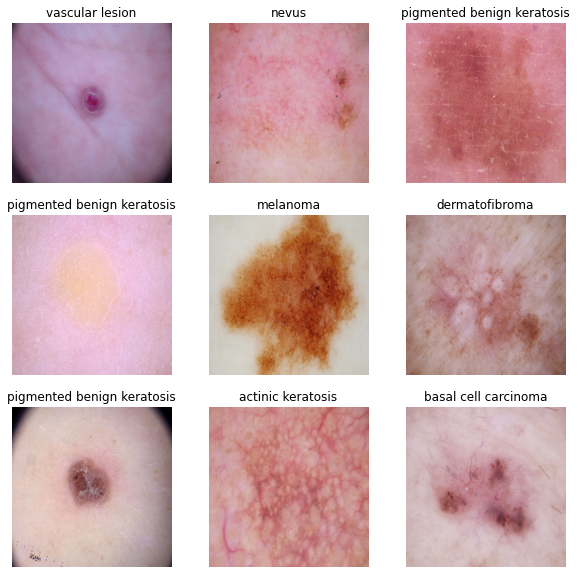

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Train the model

In [19]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 25s 72ms/step - loss: 1.9804 - accuracy: 0.2573 - val_loss: 1.8048 - val_accuracy: 0.4049
Epoch 2/20
56/56 [==============================] - 1s 18ms/step - loss: 1.6519 - accuracy: 0.4046 - val_loss: 1.6502 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 1s 17ms/step - loss: 1.5245 - accuracy: 0.4643 - val_loss: 1.4981 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3662 - accuracy: 0.5184 - val_loss: 1.4131 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 17ms/step - loss: 1.3425 - accuracy: 0.5324 - val_loss: 1.5683 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 1s 17ms/step - loss: 1.2910 - accuracy: 0.5407 - val_loss: 1.4035 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 17ms/step - loss: 1.1698 - accuracy: 0.5915 - val_loss: 1.3892 - val_accuracy: 0.5213
Epoch 8/20
56/56 [=====

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

### Visualizing training results

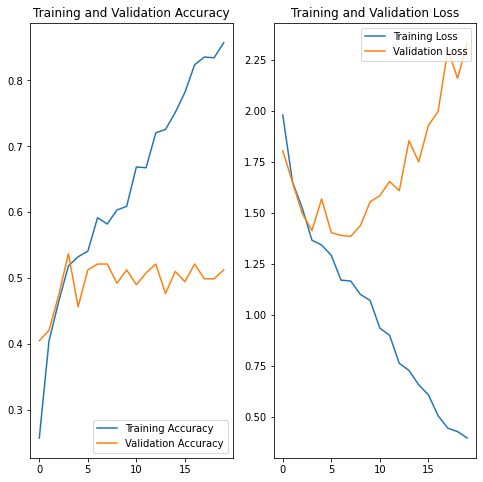

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
We can see model is overfit as validation accuracy is very less than the training accuracy. we will try data augumentation to correct the overfit issue in the next model.

### Write your findings here

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 9ms/step - loss: 2.3357 - accuracy: 0.5123
Accuracy:  0.9073660969734192
Validation Accuracy:  0.5123042464256287
Loss:  0.2575661242008209
Validation Loss 2.3356542587280273


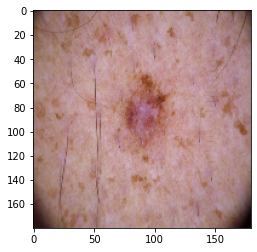

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

s_image, label = next(iter(train_ds))
_ = plt.imshow(s_image[0].numpy().astype("uint8"))
image = tf.cast(tf.expand_dims(s_image[0], 0), tf.float32)

IMG_SIZE = 180

data_augmentation = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])


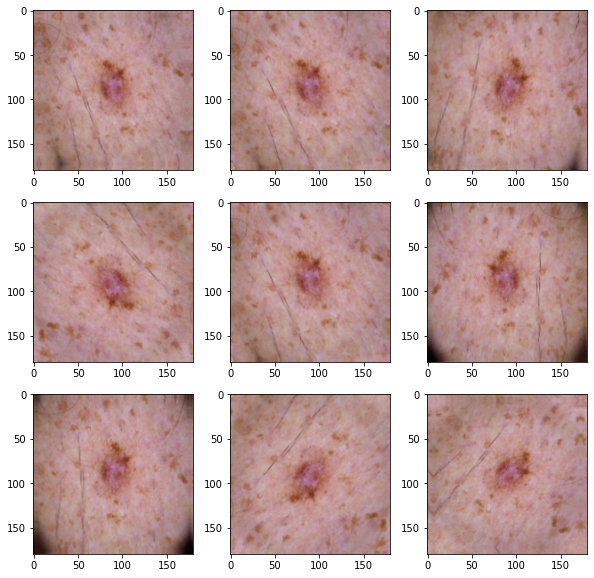

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])

### Todo:
### Create the model, compile and train the model


In [24]:
from keras.layers.core.dropout import Dropout
from keras.backend import dropout
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
## STEP 13> Fitting the CNN model

#Initializing no. of epochs and batch-size:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model_2 = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
   tf.keras.layers.MaxPooling2D(),
   Dropout(0.2),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [25]:
model_2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [26]:
# Set a learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.3, 
    min_lr=0.00001)
#callbacks=[learning_rate_reduction]

In [27]:
history_2 = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20, callbacks=[learning_rate_reduction]
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 4s 42ms/step - loss: 2.0762 - accuracy: 0.2734 - val_loss: 1.8881 - val_accuracy: 0.3468 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6618 - accuracy: 0.4057 - val_loss: 1.5009 - val_accuracy: 0.5011 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 2s 37ms/step - loss: 1.5631 - accuracy: 0.4609 - val_loss: 1.5253 - val_accuracy: 0.4966 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4337 - accuracy: 0.5123 - val_loss: 1.4921 - val_accuracy: 0.5034 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4305 - accuracy: 0.4888 - val_loss: 1.5588 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 2s 37ms/step - loss: 1.4047 - accuracy: 0.5100 - val_loss: 1.5386 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 2s 37ms/step - loss: 1.3970 - accur

### Training the model

### Visualizing the results

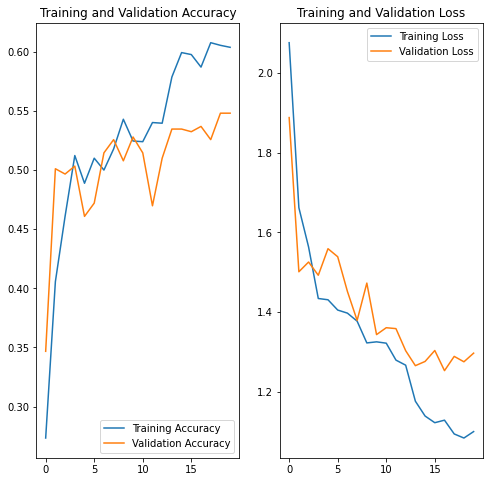

In [28]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
loss, accuracy = model_2.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_2.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 13ms/step - loss: 1.2965 - accuracy: 0.5481
Accuracy:  0.62109375
Validation Accuracy:  0.5480984449386597
Loss:  1.0862075090408325
Validation Loss 1.2964950799942017


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After adding data agumentation and dropout train and test accuracy difference is minimized.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

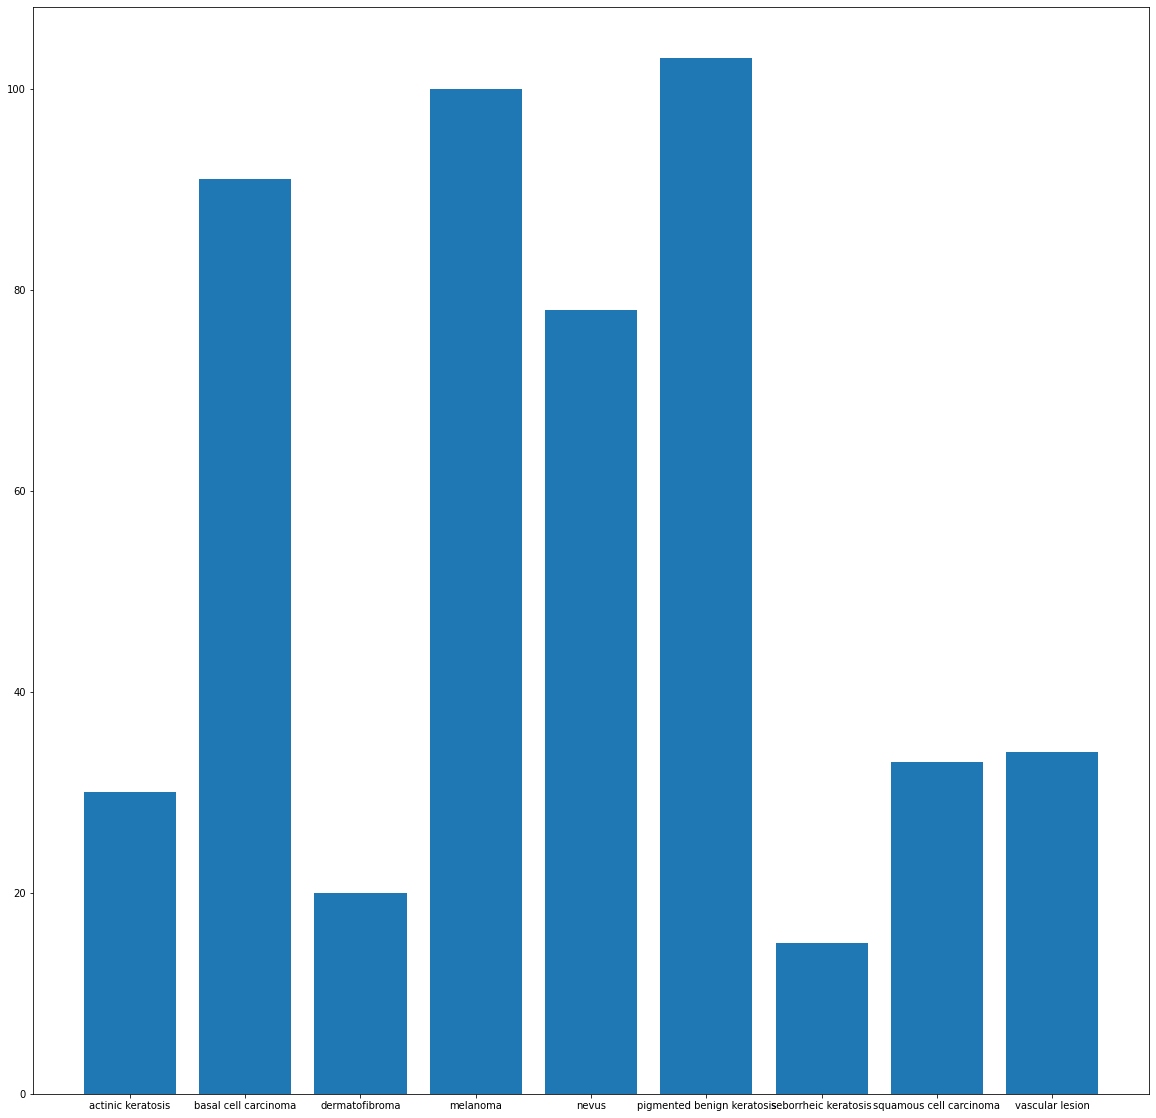

In [30]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline�s` `sample()` method.


In [35]:
path_to_training_dataset="/tmp/CNN_assignment/cnn_data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBD4C688450>: 100%|██████████| 500/500 [00:19<00:00, 25.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBD4CC2BF50>: 100%|██████████| 500/500 [00:18<00:00, 26.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBD4CB14750>: 100%|██████████| 500/500 [00:19<00:00, 25.28 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBD4C6B5490>: 100%|██████████| 500/500 [01:53<00:00,  4.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FBD4C3CB910>: 100%|██████████| 500/500 [01:27<00:00,  5.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBD4C662190>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBD4D2922D0>: 100%|██████████| 500/500 [00:45<00:00, 10.89 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBD4CAFFB50>: 100%|██████████| 500/500 [00:19<00:00, 25.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /tmp/CNN_assignment/cnn_data/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBD4C737CD0>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list = [x for x in tf.io.gfile.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010965.jpg_add63b35-2378-49b5-a5ea-2478ae9f0f08.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_29a4a3c9-113c-45bf-997f-47800fb4324c.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011137.jpg_6f1ca840-6ef6-445c-8e11-4cc8daa18815.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010990.jpg_7b0ff668-f81d-4162-b964-8ebefce5d8ad.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010878.jpg_d6e9b250-f2d8-46b8-a4e3-00fe3bdef9ce.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011181.jpg_d8f6edd9-ec19-45ba-a991-89e924084cab.jpg',
 '/tmp/CNN_assignment/cnn_data/Train/seborrheic keratosis/output/sebor

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in tf.io.gfile.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [45]:
new_df['Label'].value_counts()

seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
actinic keratosis             500
melanoma                      500
dermatofibroma                500
pigmented benign keratosis    500
basal cell carcinoma          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [47]:
data_dir_train="/tmp/CNN_assignment/cnn_data/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [91]:
## your code goes here
model_3 = tf.keras.Sequential([
  layers.Rescaling(1./255),             
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  Dropout(0.25),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  Dropout(0.4),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.BatchNormalization(),
  Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
   Dropout(0.4),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [92]:
## your code goes here
model_3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

#### **Todo:**  Train your model

In [93]:
epochs = 30
## Your code goes here, use 50 epochs.
history_3 = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 169ms/step - loss: 5.7696 - accuracy: 0.2472 - val_loss: 3.9717 - val_accuracy: 0.1121
Epoch 2/30
169/169 [==============================] - 32s 182ms/step - loss: 2.8461 - accuracy: 0.2754 - val_loss: 2.5119 - val_accuracy: 0.1069
Epoch 3/30
169/169 [==============================] - 29s 168ms/step - loss: 2.2193 - accuracy: 0.2993 - val_loss: 1.9588 - val_accuracy: 0.1990
Epoch 4/30
169/169 [==============================] - 29s 167ms/step - loss: 1.8706 - accuracy: 0.3631 - val_loss: 1.8982 - val_accuracy: 0.3007
Epoch 5/30
169/169 [==============================] - 29s 168ms/step - loss: 1.6439 - accuracy: 0.3945 - val_loss: 1.7757 - val_accuracy: 0.3422
Epoch 6/30
169/169 [==============================] - 29s 167ms/step - loss: 1.4849 - accuracy: 0.4403 - val_loss: 1.5056 - val_accuracy: 0.4284
Epoch 7/30
169/169 [==============================] - 29s 168ms/step - loss: 1.3950 - accuracy: 0.4850 - val_loss: 1.6651 - val_ac

#### **Todo:**  Visualize the model results

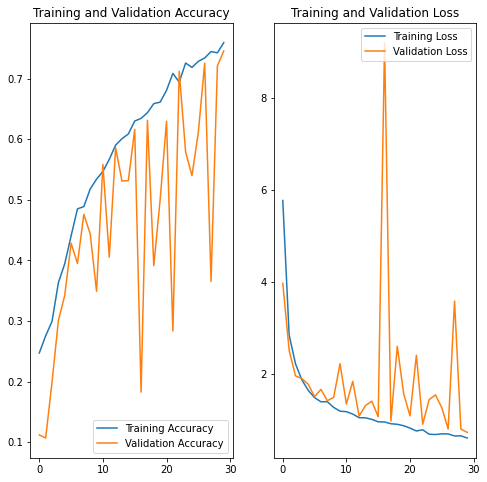

In [94]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

data agumentation and dropout helped in reducing overfitting and class rebalance helps in getting better learning and better accuracy.

